## 9. PCA и t-SNE, или зачем понижать размерность?
### PCA

Метод главных компонент, или PCA (Principal Components Analysis) — это один из базовых способов уменьшения размерности.

Рассмотрим, как запустить PCA с помощью библиотеки sklearn:

In [15]:
# из модуля decomposition библиотеки sklearn импортируем класс PCA
from sklearn.decomposition import PCA
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 
import seaborn as sns
# создаём объект класса PCA
# n_components — задаём количество компонентов для проведения трансформации
pca = PCA(n_components=2, random_state=42)

Теперь рассмотрим работу с PCA на практике. Из датасетов sklearn импортируем датасет MNIST — это данные, основанные на рукописном начертании цифр:

In [16]:
# загрузим датасет MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml("mnist_784")
# загрузим признаки в переменную X  
X = dataset['data']
# загрузим «ответы» в переменную y
y = dataset['target']
# разделим данные с помощью sklearn на данные для обучения и теста
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0)

# импортируем StandardScaler для стандартизации данных
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
# трансформируем датасеты train_x и test_x
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# импортируем класс PCA
from sklearn.decomposition import PCA

# создадим объект класса PCA
pca = PCA(n_components=300)
pca.fit(train_x)
# уменьшим размерность данных
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)

Для данного датасета обучим модель, которая по пикселям изображения предсказывает, что за цифра на нём изображена. Первой мы разработаем модель, которая будет учитывать все признаки, а затем уменьшим размерность данных с помощью PCA и ещё раз обучим модель. Далее мы сравним качество полученных моделей и время, которое было затрачено на обучение в каждом случае.

В датасете MNIST представлено 70 000 изображений, каждое из которых описывается 784 признаками.

Посмотрим, сколько признаков описывало объект до и после уменьшения размерности. Как мы можем заметить, сначала было 787 признаков, а в конце объект описывают уже 300 главных компонент:

In [17]:
print(len(train_x[0]))
print(len(train_x_pca[0]))

784
300


Обучим модель логистической регрессии, которая на вход будет принимать пиксели изображения и предсказывать, что на нём нарисовано.

Напишем функцию, которая будет принимать на вход данные для обучения (матрицу с признаками и правильные ответы) и данные для тестирования модели, а на выходе будет возвращать время, затраченное на обучение модели, и качество модели. В качестве метрики оценивания качества будем использовать метрику accuracy.

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time

# напишем функцию, которая на вход принимает X и y, а возвращает модель и время
def get_time_and_accuracy(train_x, train_y, test_x, test_y):
    # создадим объект класса LogisticRegression
    log_reg_model = LogisticRegression(max_iter=1000)
    # запишем время с начала эпохи в секундах до обучения модели
    start_time = time()
    # обучим модель
    log_reg_model.fit(train_x, train_y)    
    # запишем время с начала эпохи в секундах после обучения
    end_time = time()
    # подсчитаем время, потраченное на обучение модели
    delta_time = end_time-start_time
    # предскажем на тестовых данных
    y_pred = log_reg_model.predict(test_x)
    # посчитаем скор для тестового предсказания
    score = accuracy_score(test_y, y_pred)
    # вернём время, потраченное на обучение, и качество полученной модели
    return delta_time, score

model_pca_time, model_pca_acc = get_time_and_accuracy(train_x_pca, train_y, test_x_pca, test_y)
print(f"Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения {model_pca_time}, метрика модели {model_pca_acc}")
# Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 54.12072825431824, метрика модели 0.9255714285714286

model_time, model_acc = get_time_and_accuracy(train_x, train_y, test_x, test_y)
print(f"Модель, построенная на всех исходных признаках. Время обучения {model_time}, метрика модели {model_acc}")
# Модель, построенная на всех исходных признаках. Время обучения 108.04033303260803, метрика модели 0.9187142857142857

Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 13.34578824043274, метрика модели 0.9257142857142857
Модель, построенная на всех исходных признаках. Время обучения 16.29488515853882, метрика модели 0.9181428571428571


Как видим, в данном случае мы потратили на обучение модели в два раза меньше времени, а качество осталось практически таким же.

В реальной работе бывает гораздо больше данных и на обучение модели уходит отнюдь не две минуты. Таким образом, применив технику уменьшения размерности, можно существенно сэкономить время.

→ Мы научились ускорять обучение моделей с помощью понижения размерности данных, а теперь давайте научимся визуализировать многомерное пространство.

### t-SNE

Для того чтобы визуализировать многомерное пространство признаков, необходимо уменьшить его размерность до двухмерного или трёхмерного. В этом поможет t-SNE (t-distributed Stochastic Neighbor Embedding), что переводится с английского как «стохастическое вложение соседей с t-распределением». 

t-SNE, в отличие от PCA, использует технику нелинейного снижения размерности данных. Обычно используется снижение размерности многомерного пространства до двух- или трёхмерного с целью дальнейшей визуализации. При преобразовании похожие объекты оказываются рядом, а непохожие — далеко друг от друга.

In [19]:
# импортируем класс TSNE из модуля manifold библиотеки sklearn
from sklearn.manifold import TSNE

# создаём объект класса TSNE
# n_components — размерность нового пространства
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
# обучаем модель на данных X и производим трансформацию
tsne.fit_transform(X)

d:\Python\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


array([[ 15.680719  ,  -0.04038009],
       [ 31.388723  ,  18.571693  ],
       [ 17.220476  , -37.40977   ],
       ...,
       [  4.1987267 , -20.259983  ],
       [ 10.289323  , -11.740335  ],
       [ 29.260271  , -16.530415  ]], dtype=float32)

Важные параметры для запуска:

- n_components — размерность нового пространства.
- perplexity — один из важнейших параметров для запуска. Этот параметр описывает ожидаемую плотность вокруг точки. Таким образом мы можем устанавливать соотношение ближайших соседей к точке. Если датасет большой, стоит установить большее значение perplexity. Обычно используют - значения в диапазоне от 5 до 50.
- n_iter — количество итераций для оптимизации.
- random_state — так как в алгоритме есть случайность, задание random_state позволяет от запуска к запуску получать одинаковые результаты.

d:\Python\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

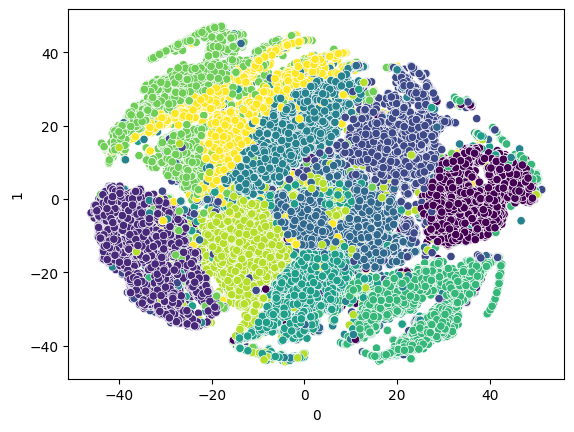

In [20]:
# создадим объект класса TSNE, уменьшим размерность данных до 2
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=42)
# уменьшим размерность данных
X_reduced = tsne.fit_transform(train_x)
# сохраним данные в датафрейм
df_tsne = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_tsne['c'] = pd.to_numeric(train_y).astype('Int64').to_list()
# визуализируем
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], c=df_tsne['c'])

Как видим, алгоритм t-SNE отлично справляется с уменьшением размерности для визуализации, а вот при использовании PCA данные не разделились на кластеры и пересекаются друг с другом — такую визуализацию будет неудобно анализировать.